# TempAtt exp2 (auditory - passive&tracking)

### Load & preprocess data

In [54]:
clear
clc
% close all

In [55]:
% define Paths: replace XXX by your own path
origDir = '/XXX/exp2/';
addpath(genpath(origDir)); cd(origDir)

% define data
SUJETS = 1:21;
SUJETS(SUJETS==15) = [];

In [56]:
% load data: 2 sessions per participant
cd(origDir)
IN = []; Dif = NaN(SUJETS(end),1);
for isuj = SUJETS
    subject = ['S' sprintf( '%02d', isuj ) ];
        ifile = dir(['TA18_' subject '_Listen_1*.mat']);
        load([ifile.name])
        IN{isuj,1}  = X;
        Dif(isuj,1) = cfg.ndis;
    subject = ['S' sprintf( '%02d', isuj ) ];
        ifile = dir(['TA18_' subject '_Tracking_1*.mat']);
        load([ifile.name]) 
        IN{isuj,2}  = X;
        Dif(isuj,2) = cfg.ndis;
    clear X subject ifile
    
    if Dif(isuj,1) ~= Dif(isuj,2)
    fprintf('Problem! : difficulty level was not matched across sessions')
    end
end
Dif = mean(Dif,2);

In [57]:
% varnames & beat
varname = {'Proportion Correct', 'Mean RT (ms)', 'Hit IE (sec)'};
beats = cfg.fbeat(end:-1:1);

In [58]:
% extract data
OUT{1} = NaN(SUJETS(end), length(cfg.fbeat), 2); OUT{2} = OUT{1}; OUT{3} = OUT{2};
for isuj = SUJETS
    for itapp = 1:2
        for ibeat = 1:length(beats)
            y = IN{isuj,itapp}.beat == beats(ibeat);
            out{1} = IN{isuj,itapp}.iscor(y);
            out{2} = IN{isuj,itapp}.rt(y);
            % nan rt >|< 2sd
                rtmin = mean(out{2}) -2*std(out{2});
                rtmax = mean(out{2}) +2*std(out{2});
                out{2}(out{2}>rtmax)  = NaN; out{2}(out{2}<rtmin) = NaN;
                out{1}(isnan(out{2})) = NaN;
            % avg trials
                OUT{1}(isuj,ibeat,itapp) = nanmean(out{1});
                OUT{2}(isuj,ibeat,itapp) = nanmean(out{2});
                OUT{3}(isuj,ibeat,itapp) = nanmean(out{2}) ./nanmean(out{1});
            clear out y rtmin rtmax
        end
    end
end
clear IN  isuj ibeat itapp

In [59]:
% Load tapping data
load([origDir 'exp2_tapping.mat'], 'TAPP'); % TAPP
load([origDir 'exp2_lag.mat']); % LAG (generated in: "exp2 figure2&S2 (suite)")

In [60]:
% remove phantom (NaN) participant
OUT{1}(isnan(OUT{1}(:,1,1)),:,:) = [];
OUT{2}(isnan(OUT{2}(:,1,1)),:,:) = [];
OUT{3}(isnan(OUT{3}(:,1,1)),:,:) = [];
TAPP(isnan(nanmean(TAPP(:,1,1,:),4)), :,:,:) = [];
Dif(isnan(Dif)) = [];

In [61]:
% define variable of interest
i0 = 1; % performance (or RT, or IE, see varname)
fit_order = 3; % fit order (n = 3)

In [62]:
% Fits per subject - define after rstudio analysis
xVec = (beats(end):0.01:beats(1));
Fit = [];
for j0 = 1:length(OUT{i0})
    for k0 = 1:2
        x = OUT{i0}(j0,:,k0);
        x = polyfit(log(beats), x, fit_order);
        if fit_order == 3
            Fit(j0,k0) = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
        elseif fit_order == 2
            Fit(j0,k0) = exp(-(x(2)./(2.*x(1)))); % order 2
        end
    end
end

% Fit motor tapping data
z = nanmean(TAPP(:,:,2,:)*100, 4);
for j0 = 1:size(z,1)
    x = z(j0,:);
    x = polyfit(log(beats), x, fit_order);
    if fit_order == 3
        Fit(j0,3) = exp((-x(2)+sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    elseif fit_order == 2
        Fit(j0,3) = exp(-(x(2)./(2.*x(1)))); % order 2
    end        
end
Fit = real(Fit);
nsuj = length(Fit);
clear j0 k0

% save data for inter-experiment comparisons
save([origDir 'exp2_values.mat'], 'Fit', 'TAPP');

In [63]:
% detect potential outliers (4std) in the Fit
for j0 = 1:size(Fit,2)
    olr = find((Fit(:,j0)>(mean(Fit(:,j0))+4*std(Fit(:,j0)))));
end
[min(Fit(:)), max(Fit(:))] % edit range of Fit fq


ans =

    0.5012    2.6797



### Figure A

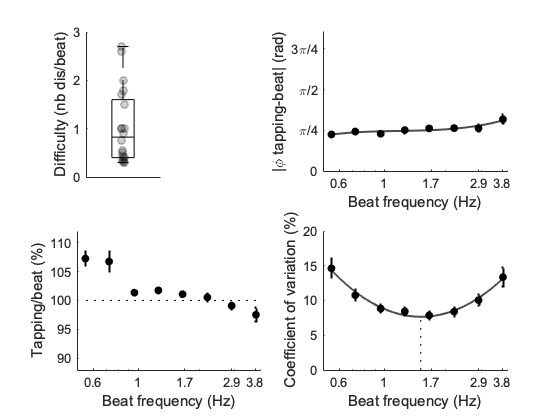

In [64]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])

% 1. Difficulty
h = subplot(2,4, 1); hold on
    % pos = get(h, 'Position');
    % set(h, 'Position', pos +[-.08 0 0 0] )
    boxplot(zeros(10,1), 'colors','k','Widths',.01)
boxplot(Dif,'boxstyle','outline', 'colors','k','OutlierSize',4,'Symbol','','Widths',0.6)
scatter(ones(size(Dif)).*(1+(rand(size(Dif))-0.5)/10),Dif, ...
    'MarkerFaceColor',[.1 .1 .1],'MarkerEdgeColor','k',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylim( [0, 3] )
    ylabel( 'Difficulty (nb dis/beat)' )
    xlim( [.0, 2] )
    set(gca,'XTick', [] )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    
% 2. beat-tapping Lag
subplot(2,2, 2); hold on
x = nanmean(LAG,4);    
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    '.','color', 'k', 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
x = mean(nanmean(LAG(:,:,1,:)), 4);
    x = polyfit(log(beats), x, fit_order);
    freqCVmin = exp((-x(2)+sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    x = polyval(x, log(xVec));
    h = plot(xVec, x, 'color', 'k', 'Linewidth', 1.5);
    h.Color(4) = 0.7;
    
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( '|\phi tapping-beat| (rad)' )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
	ylim( [0, 2.7] )
    yticks( [0 pi/4 pi/2 3*pi/4] )
    yticklabels({'0','\pi/4','\pi/2', '3\pi/4'})
        xticks( round(beats([end:-2:1 1]),1) )       
        set(gca, 'XScale', 'log')
        xlim( [.5, 4] )
   
% 3. mean: actual/expected (tapspeed)
subplot(2,2, 3); hold on
x = nanmean(TAPP,4);
x = 1e3./x(:,:,1); % in Hz
    x = bsxfun(@rdivide, x, beats)*100; % actual/expected
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    '.','color', 'k', 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
        hold on; plot(beats, 100*ones(1,length(beats)),'k:'); hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( 'Tapping/beat (%)' )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    ylim( [88, 112] )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.5, 4] )
   
% 4. coefficient of variation (std/mean*100)
subplot(2,2, 4); hold on
x = nanmean(TAPP,4);    
x = x(:,:,2)*100; % in Hz
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    '.','color', 'k', 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
x = mean(nanmean(TAPP(:,:,2,:)*100, 4));
    x = polyfit(log(beats), x, fit_order);
    freqCVmin = exp((-x(2)+sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    x = polyval(x, log(xVec));
    h = plot(xVec, x, 'color', 'k', 'Linewidth', 1.5);
    h.Color(4) = 0.7;
% plot min fit
[~,b] = min(x);
    minCV = min(x);
h = line([xVec(b), xVec(b)], [.0, min(x)]);
    set(h, 'color', 'k', 'LineStyle', ':')
    
hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    xlim( [.5, 4] )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlabel( 'Beat frequency (Hz)' )
    ylim( [0, 20] )
        ylabel( 'Coefficient of variation (%)' ) % Tapping precision fn beat(ms/Hz)
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
  clear  h 

% Print figure
cd(origDir)
% print('figure2c&S2a','-dpng','-r600')
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figure2c&S2a.pdf


In [65]:
fprintf('min CV from indiv Fit:  mean = %1.4f Hz, med = %1.4f Hz, std = %1.4f Hz \n', mean(Fit(:,3)), quantile(Fit(:,3),[.5]), std(Fit(:,3)))
fprintf('min CV from group averaged data:  %1.2f %%, %1.2f Hz \n', mean(minCV), freqCVmin)


min CV from indiv Fit:  mean = 1.4179 Hz, med = 1.4072 Hz, std = 0.4439 Hz 
min CV from group averaged data:  7.66 %, 1.51 Hz 


## Stat 

In [66]:
% Anova
fprintf('\nParametric repeated-measure Anova on %s \n', varname{i0})
x = nanmean(TAPP(:,:,2,:)*100, 4);
[~,F,~,~] = repanova(x, 8, {'Beat'});

% compute fit quality
x = mean(x);
    y = polyfit(log(beats), x, fit_order);
    y = polyval(y, log(beats));
[r,p] = corr(x', y', 'type', 'Spearman');
fprintf('\n%1.0fnd order fit: r2=%1.2f, p=%1.3f \n', fit_order, r*r, p)


Parametric repeated-measure Anova on Proportion Correct 
Beat                 F(  7.00,133.00) =   6.837,	p = 0.0005

3nd order fit: r2=0.95, p=0.000 


### Figure B

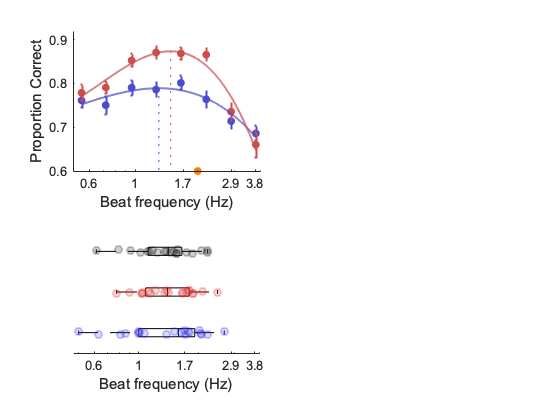

In [67]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])
    
% 1. plot performances
subplot(2,2, 1); hold on
x = OUT{i0}(:,:,1); % listen
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.3 .3 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
x = OUT{i0}(:,:,2); % tracking
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.8 .3 .3], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)

% plot staircase
plot(2, .6, '.', 'color', [1 .5 .0], 'Linewidth', 2, 'MarkerSize', 15) %!
        
% Listen: plot Fit & max fit
x = mean(OUT{i0}(:,:,1),1); % listen
    x = polyfit(log(beats), x, fit_order);
    freqpass = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    x = polyval(x, log(xVec));
    h = plot(xVec, x, 'color', [.3 .3 .8], 'Linewidth', 1.5);
    h.Color(4) = 0.7;
[~,b] = max(x);
    maxpass = max(x);
    h = line([xVec(b), xVec(b)], [.0, max(x)]);
    set(h, 'color', [.3 .3 .8], 'LineStyle', ':')
 
% Tracking: plot Fit & max fit    
x = mean(OUT{i0}(:,:,2),1); % tracking
    x = polyfit(log(beats), x, fit_order);
    freqtrack = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    x = polyval(x, log(xVec));
    h = plot(xVec, x, 'color', [.8 .3 .3], 'Linewidth', 1.5);
    h.Color(4) = 0.7;     
[~,b] = max(x);
    maxtrack = max(x);
    h = line([xVec(b), xVec(b)], [.0, max(x)]);
    set(h, 'color', [.8 .3 .3], 'LineStyle', ':')  
        
hold off
set(gca, 'FontSize', 10, 'FontName', 'Arial')
ylabel( varname{i0} )        
xlabel( 'Beat frequency (Hz)' )
set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
ylim( [.6, .92] ) %!
yticks( .5:.1:1 )       
    xticks( round(beats([end:-2:1 1]),1) )
    set(gca, 'XScale', 'log')
    xlim( [.5, 4] )
    

% 2. boxplot individual preferred Fq
subplot(2,2, 3); hold on
boxplot(Fit,'orientation', 'horizontal','boxstyle','outline', 'colors','k','OutlierSize',4,'Symbol','','Widths',0.2)

scatter(Fit(:,1),ones(nsuj,1).*(1+(rand(nsuj,1)-0.5)/10),  ...
    'MarkerFaceColor',[.3 .3 .8],'MarkerEdgeColor','b',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
scatter(Fit(:,2),ones(nsuj,1).*(2+(rand(nsuj,1)-0.5)/10),  ...
    'MarkerFaceColor',[.8 .3 .3],'MarkerEdgeColor','r',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
scatter(Fit(:,3),ones(nsuj,1).*(3+(rand(nsuj,1)-0.5)/10),  ...
    'MarkerFaceColor',[.1 .1 .1],'MarkerEdgeColor','k',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
set(gca, 'FontSize', 10, 'FontName', 'Arial')
set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
xlabel( 'Beat frequency (Hz)' )
    xticks( round(beats([end:-2:1 1]),1) )
    set(gca, 'XScale', 'log')
    xlim( [.47, 4] )
yticks( [] )
set(gca, 'YColor', [1 1 1])    

% print figure
cd(origDir)
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figure2a&d.pdf

### Statistics listen vs. tracking

In [77]:
% Anova
pval = [];
fprintf('\nParametric repeated-measure Anova on %s \n', varname{i0})
[~,F,~,~] = repanova( reshape(OUT{i0}, length(SUJETS),[]), [2,8], {'Condition','Beat'});

% Post-hoc analysis: tracking vs. listen (beat-by-beat)
fprintf('\n')
for j0 = 1:length(beats)
    [~, p, ~, S] = ttest(OUT{1}(:,j0,2), OUT{1}(:,j0,1));
    bf = bftest(OUT{1}(:,j0,2)-OUT{1}(:,j0,1),'bic'); 
    fprintf('     beat %1.2fhz: p= %6.4f,  t= %6.4f,  df= %6.2f, bf= %6.2f\n', beats(j0), p, S.tstat,S.df, bf)
    pval(j0) = p;
end

% comparison of passive|tracking|tapping
 fprintf('\n')
 fprintf('Tapping :  mean = %1.2f , med = %1.2f , std = %1.3f  \n', mean(Fit(:,3)), quantile(Fit(:,3),[.5]), std(Fit(:,3)))
 fprintf('Tracking :  mean = %1.2f , med = %1.2f , std = %1.3f  \n', mean(Fit(:,2)), quantile(Fit(:,2),[.5]), std(Fit(:,2)))
 fprintf('Passive :  mean = %1.2f , med = %1.2f , std = %1.3f  \n', mean(Fit(:,1)), quantile(Fit(:,1),[.5]), std(Fit(:,1)))
 fprintf('\n')
[h,p,ci,stats] = ttest(Fit(:,1),Fit(:,2));
    bf = bftest(Fit(:,1)-Fit(:,2),'bic'); 
     fprintf('Passive vs  Tracking:  t = %1.2f ,  df= %6.2f, p = %1.2f, bf = %6.2f \n',stats.tstat,stats.df, p, bf)
[h,p,ci,stats] = ttest(Fit(:,1),Fit(:,3));
    bf = bftest(Fit(:,1)-Fit(:,3),'bic'); 
     fprintf('Passive vs  Tapping:   t = %1.2f ,  df= %6.2f, p = %1.2f, bf = %6.2f \n',stats.tstat,stats.df, p, bf)
[h,p,ci,stats] = ttest(Fit(:,2),Fit(:,3));
    bf = bftest(Fit(:,2)-Fit(:,3),'bic'); 
     fprintf('Tracking vs  Tapping:  t = %1.2f ,  df= %6.2f, p = %1.2f, bf = %6.2f \n',stats.tstat,stats.df, p, bf)



Parametric repeated-measure Anova on Proportion Correct 
Condition            F(  1.00, 19.00) =   7.520,	p = 0.0129
Beat                 F(  7.00,133.00) =  15.988,	p = 0.0000
Condition x Beat     F(  7.00,133.00) =   2.808,	p = 0.0234

     beat 3.82hz: p= 0.3666,  t= -0.9250,  df=  19.00, bf=   0.35
     beat 2.90hz: p= 0.4277,  t= 0.8105,  df=  19.00, bf=   0.31
     beat 2.20hz: p= 0.0019,  t= 3.5987,  df=  19.00, bf=  40.43
     beat 1.66hz: p= 0.0087,  t= 2.9252,  df=  19.00, bf=   9.21
     beat 1.26hz: p= 0.0129,  t= 2.7445,  df=  19.00, bf=   6.31
     beat 0.96hz: p= 0.0663,  t= 1.9486,  df=  19.00, bf=   1.38
     beat 0.72hz: p= 0.1863,  t= 1.3712,  df=  19.00, bf=   0.57
     beat 0.55hz: p= 0.5616,  t= 0.5909,  df=  19.00, bf=   0.27

Tapping :  mean = 1.42 , med = 1.41 , std = 0.444  
Tracking :  mean = 1.47 , med = 1.40 , std = 0.445  
Passive :  mean = 1.47 , med = 1.58 , std = 0.590  

Passive vs  Tracking:  t = 0.02 ,  df=  19.00, p = 0.99, bf =   0.22 
Passive vs 

In [80]:
% compute fit quality for passive & tracking conditions
x = mean(OUT{i0}(:,:,1),1);
    y = polyfit(log(beats), x, fit_order);
    y = polyval(y, log(beats));
[r,p] = corr(x', y', 'type', 'Spearman');
fprintf('passive: %1.0fnd order fit: r2=%1.2f, p=%1.3f', fit_order, r*r, p)

x = mean(OUT{i0}(:,:,2),1);
    y = polyfit(log(beats), x, fit_order);
    y = polyval(y, log(beats));
[r,p] = corr(x', y', 'type', 'Spearman');
fprintf('\ntracking: %1.0fnd order fit: r2=%1.2f, p=%1.3f \n', fit_order, r*r, p)

passive: 3nd order fit: r2=0.73, p=0.011
tracking: 3nd order fit: r2=0.91, p=0.001 


### Statistics exp1 vs. exp2

In [81]:
% passive conditions: first vs second auditory exp

% load data from experiment 1 to compare experiments
A = load('../exp1/exp1_values.mat', 'Fit'); % Fit
X = Fit(:,1); Y = A.Fit; % Y = Fit(:,3);
[h,p,ci,stats] = ttest2(X,Y, 'Vartype', 'unequal'); % unpaired welsh ttest

% implementation maison Bayes Factor unpaired
    T = stats.tstat;
    df = numel(X)+numel(Y)-2;
    N = numel(X)*numel(Y)/(numel(X)+numel(Y));
    r = sqrt(2)/2; % Ã  voir !!! .7 or 1...

numerator = (1+T.^2/df).^(-(df+1)/2);
fun  = @(g) ( ((1+N.*g.*r.^2).^-0.5) .* (1+T.^2./((1+N.*g.*r.^2).*df)).^(-(df+1)/2) .* (2*pi).^(-1/2) .* g.^(-3/2).*exp(-1./(2*g))  );
bf10 = numerator/integral(fun,0,inf); % Integrate over g
bf10 = 1./bf10; % Return BF10
% bf10 = 2*(1-pValue)*bf10; % if one-tail

fprintf('comparison of exp1 & exp2a: \n');
fprintf('   passive2 vs  passive1:  t = %1.2f  df= %6.2f, , p = %1.2f, bf = %6.2f \n',stats.tstat,stats.df, p, bf10)
fprintf('   df (without Welch-Satterthwaite correction) = %1.0f\n',df);
clear h p ci stats

comparison of exp1 & exp2a: 
   passive2 vs  passive1:  t = 0.66  df=  47.45, , p = 0.51, bf =   0.34 
   df (without Welch-Satterthwaite correction) = 48
